In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from PIL import Image
import numpy as np

def get_training_data(image_path):
    """Loads an image from the given path into a numpy array."""
    with Image.open(image_path) as img:
        return np.array(img)

In [5]:
bad_dir = './Datasets/Lung_images/malignant'
good_dir = './Datasets/Lung_images/benign'

In [6]:
x, y = [], []

for i in os.listdir(bad_dir + '/'):
    img = plt.imread(bad_dir + '/' + i)
    img = np.array(img)
    
    if img.shape[0] == 512 and img.shape[1] == 512 and img.shape[2] == 3:
        x.append(img)
        y.append(1)

for i in os.listdir(good_dir + '/'):
    img = plt.imread(good_dir + '/' + i)
    img = np.array(img)
    if img.shape[0] == 512 and img.shape[1] == 512 and img.shape[2] == 3:
        x.append(img)
        y.append(0)

x = np.asarray(x)
y = np.asarray(y)
x = x / 255.0

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(372, 512, 512, 3) (372,)
(124, 512, 512, 3) (124,)
(125, 512, 512, 3) (125,)


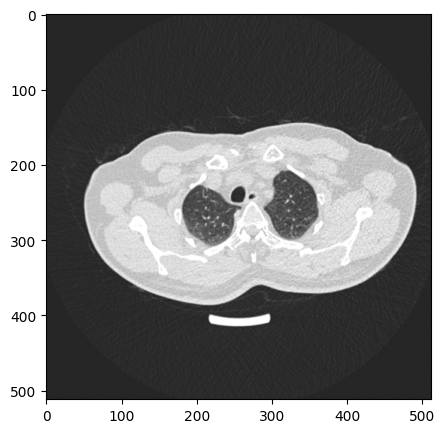

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[2], cmap='gray')

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (512,512,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 512, 512, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 64)      2

In [11]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
12/12 [==============================] - 112s 9s/step - loss: 12.6625 - accuracy: 0.7177 - val_loss: 3.8586 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/12
12/12 [==============================] - 96s 8s/step - loss: 0.3532 - accuracy: 0.8441 - val_loss: 18.4353 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/12
12/12 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.9032
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
12/12 [==============================] - 100s 8s/step - loss: 0.3288 - accuracy: 0.9032 - val_loss: 19.8684 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/12
12/12 [==============================] - 99s 8s/step - loss: 0.1664 - accuracy: 0.9382 - val_loss: 28.5376 - val_accuracy: 0.8000 - lr: 3.0000e-04
Epoch 5/12
12/12 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.9382
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
12/12 [==============================] - 94s 7s/s

In [23]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

4/4 [==============================] - 4s 783ms/step - loss: 50.5772 - accuracy: 0.8387
Loss of the model is -  50.57716369628906
4/4 [==============================] - 4s 810ms/step - loss: 50.5772 - accuracy: 0.8387
Accuracy of the model is -  83.87096524238586 %


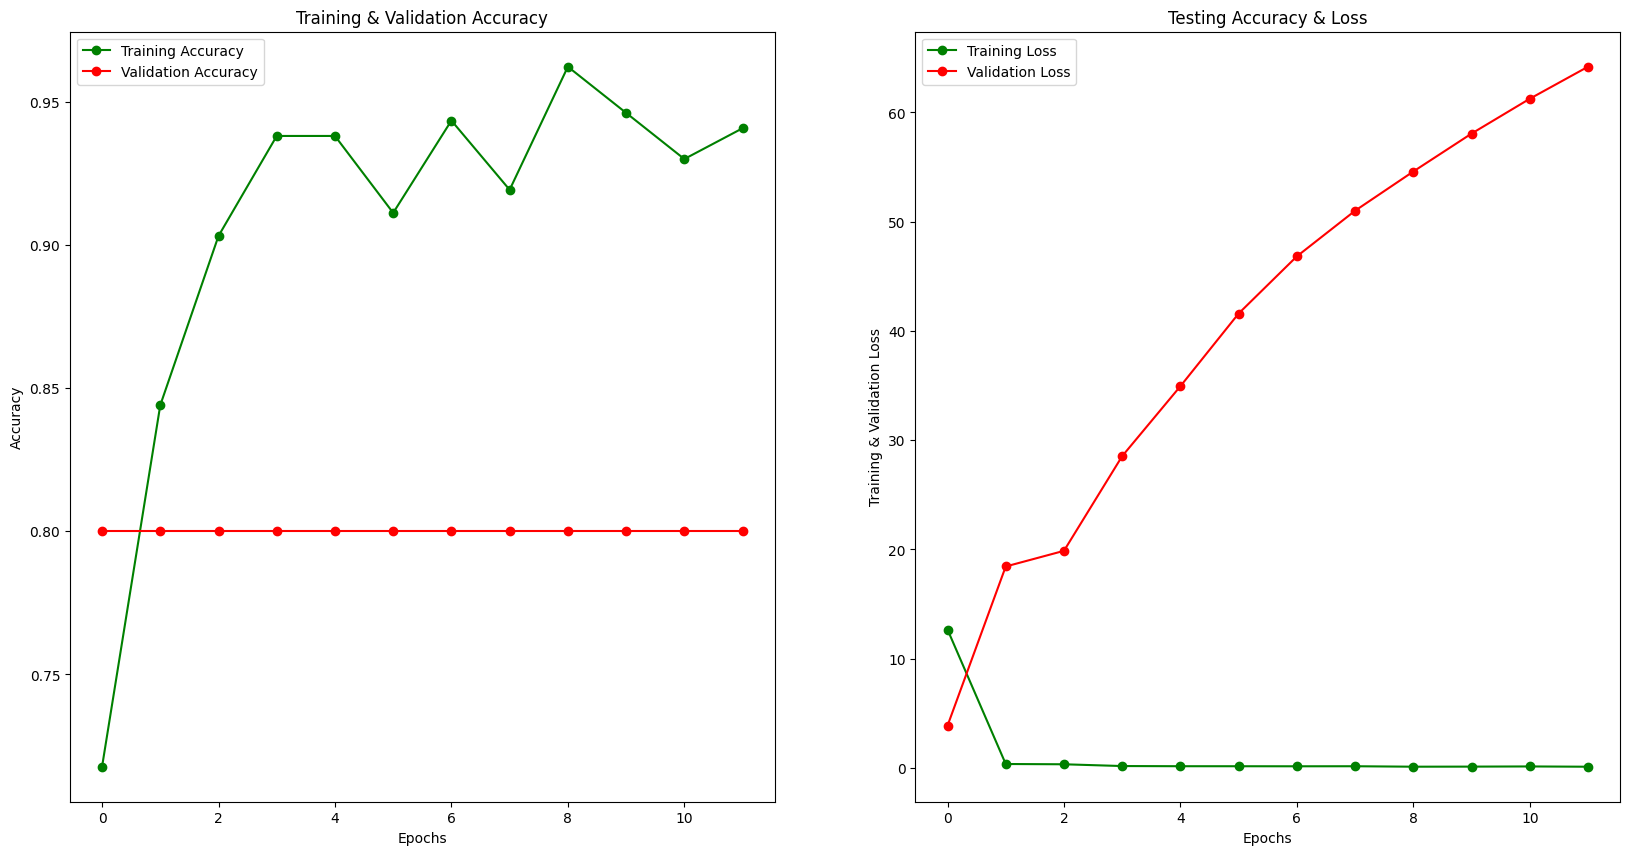

In [24]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [25]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

for i in range(len(predictions)):
    predictions[i] = (predictions[i] >= 0.5)

4/4 [==============================] - 4s 810ms/step


In [26]:
print(classification_report(y_test, predictions, target_names = ['Benign (Class 0)','Malignant (Class 1)']))

                     precision    recall  f1-score   support

   Benign (Class 0)       0.00      0.00      0.00        20
Malignant (Class 1)       0.84      1.00      0.91       104

           accuracy                           0.84       124
          macro avg       0.42      0.50      0.46       124
       weighted avg       0.70      0.84      0.77       124



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
cm = confusion_matrix(y_test,predictions)
cm

array([[  0,  20],
       [  0, 104]])

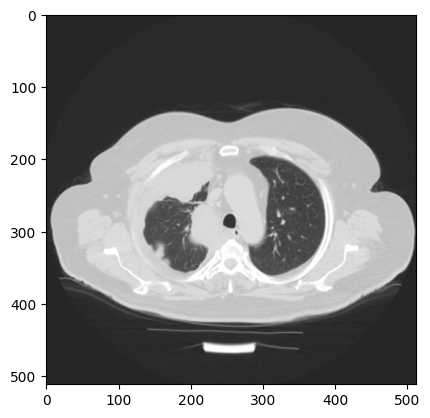

In [28]:
plt.imshow(x_test[0])

In [29]:
test_prediction = model.predict(np.array([x_test[1]]))

1/1 [==============================] - 0s 42ms/step


In [30]:
test_prediction

array([[1.]], dtype=float32)

In [31]:
model.save_weights('cnn_weights.h5')

In [32]:
def getModelArchitecture():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (512,512,3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()
    return model

test = getModelArchitecture()  # assuming you have a function to create your model architecture
test.load_weights('cnn_weights.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 512, 512, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 512, 512, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 256, 256, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 64)     

In [ ]:
def getModelArchitecture():
        model = Sequential()
        model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (512,512,3)))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
        model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
        model.add(Dropout(0.1))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
        model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
        model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
        model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
        model.add(Flatten())
        model.add(Dense(units = 128 , activation = 'relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units = 1 , activation = 'sigmoid'))
        model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
        model.summary()
        return model

In [36]:
test_model = getModelArchitecture()  # assuming you have a function to create your model architecture
test_model.load_weights('./cnn_weights.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 batch_normalization_15 (Ba  (None, 512, 512, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 256, 256, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 dropout_12 (Dropout)        (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_16 (Ba  (None, 256, 256, 64)     

In [39]:
test_prediction = test_model.predict(np.array([x_test[1]]))

1/1 [==============================] - 0s 121ms/step


In [38]:
test_prediction

array([[1.]], dtype=float32)